# Classification - Fashion Mnist

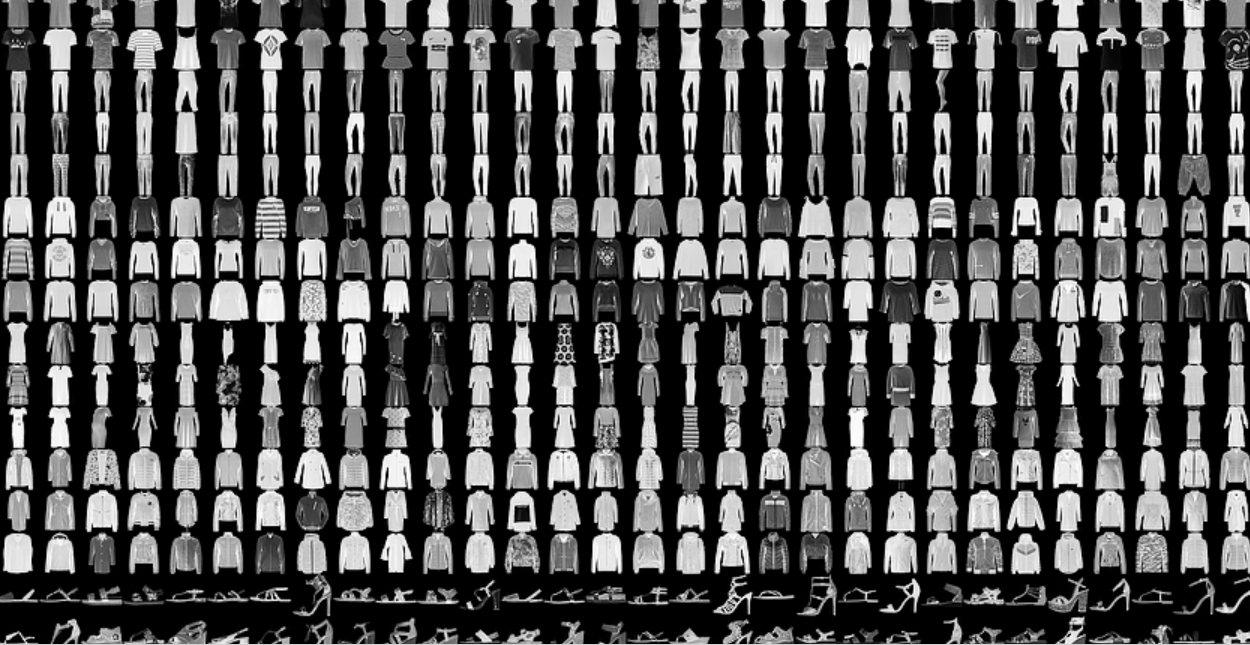

## Table of Contents
* **Main goal**.
* **Creating the DataFrame**.
* **Cleaning the data**.
* **Label casting**.
* **Spliting the train part**.
* **Fashion show**.
* **Spliting the data into train and test parts**.
* **Dimensional reduction**.
* **Pipeline**.
* **Models**.
* **Conclusion**.

## Main goal
Predict the cloth label of a given image according to the pixel values it has.

In [1]:
# importing the neccesary libraries
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Creating the Dataframe
The csv files that of the given train and test data

In [2]:
# the data is already split to train and test
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

In [3]:
# the first 5 rows of the data
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# As we can see, we have a lot to train on
df_train.shape

(60000, 785)

In [5]:
# and a lot to test on
df_test.shape

(10000, 785)

## Cleaning the data

In [6]:
df_train.isnull().sum().sum()

0

In [7]:
df_test.isnull().sum().sum()

0

as we can see, the data is already cleanes in the train and the test

## Label casting

In [8]:
# number of different lables (clothes)
df_train['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

As we can see, we have 10 different clothing types.

Let's cast them into strings when we would like to present them!

In [9]:
# a function that "translate" a label number to the clothing type it present
def label_numbers_to_clothes(lables):
    casting = {0 :'T-Shirt/Top',
               1 :'Trouser',
               2 :'Pullover',
               3 :'Dress',
               4 :'Coat',
               5 :'Sandal',
               6 :'Shirt',
               7 :'Sneaker',
               8 :'Bag',
               9 :'Ankle Boot'}
    label_copy = lables.copy().map(casting)
    return label_copy

## Spliting the train part
the target will be the label column (which we want to predict)

the features will be the whole data except the label column (through that data we will predict the label)

In [12]:
targets_train = df_train['label']
features_train = df_train.drop(['label'], axis = 1)

## Fashion show

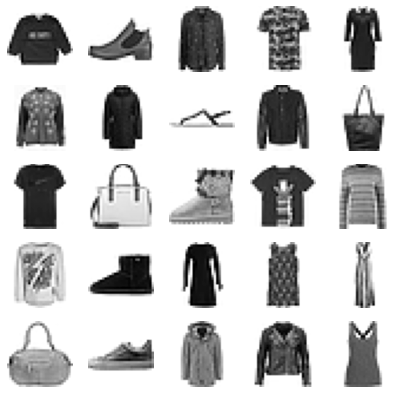

In [13]:
# let's present some of data by image
fig, ax = plt.subplots(5,5, figsize=(7,7))
ax= ax.ravel()
for i in range(25):
    ax[i].imshow(features_train.values.reshape(features_train.shape[0],28,28)[i], cmap = 'binary') 
    ax[i].axis('off')
plt.show()

Let's check if the data is distributed equally

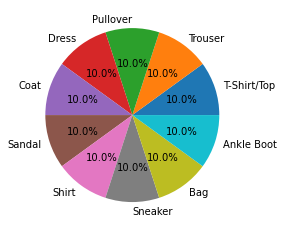

In [14]:
items_dict = dict(targets_train.value_counts())
lables = items_dict.keys()
lables = pd.Series(lables)
values = items_dict.values()
plt.pie(values, labels=label_numbers_to_clothes(lables), autopct='%1.1f%%')
plt.show()

As we can see, each label number (clothing type) has the same data percent as everyone else,
means that the data is perfectly balanced

## Spliting the data into train and test parts
The train_test_split() method splits the data according to a random state, if we'll choose some random state, than over multiple reruns, the resulting dataframes from the method remain the same (we chose random state 7).

In [15]:
X_train, X_val, y_train, y_val = train_test_split(features_train, targets_train, test_size=0.2, random_state=7)

# Dimensional reduction
we have a lot of data amout (784 pixels), if we can decrease the number of pixels our model will learn from, it will help us
doing it way more faster.

In [16]:
# First of all, let's see how much the data is affected by each column
pca = PCA()
pca.fit(X_train)

PCA()

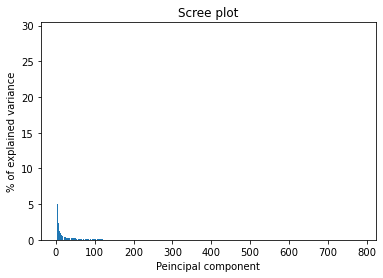

In [17]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()

from here we can see that not all of the pixels are relevant for predicting the clothing type.

Moreover, most of the variation is along the first PC (pixel 1)

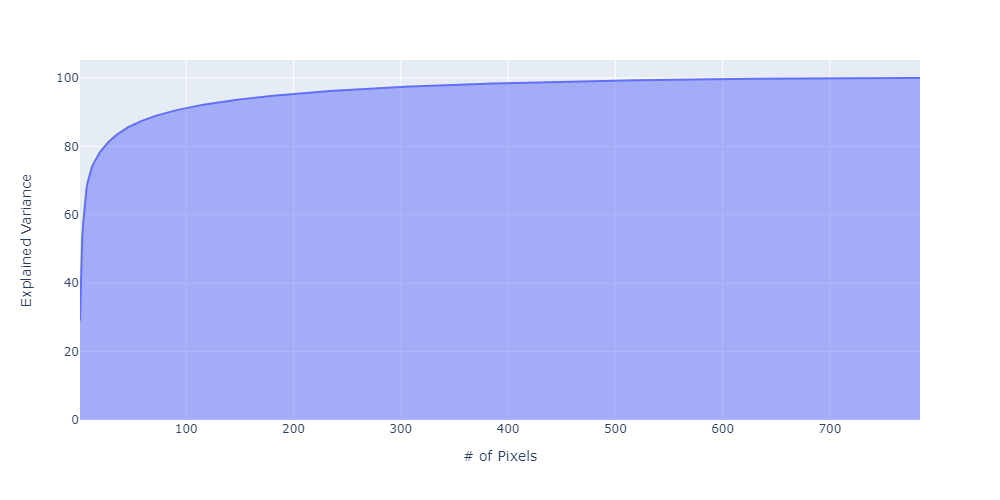

In [18]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0]+1),
    y=exp_var_cumul * 100,
    labels={"x": "# of Pixels", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)

fig.show("png")

from here we can actually see how much data percent we can get using number of pixels

In [19]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

187

if we would like to get a 95% of our data accuracy, we need only 187 columns.

that's great, but not enough..
let's try to reduce the number of columns more

In [20]:
pca = PCA(n_components=0.9)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

84

to get a 90% of our data accuracy, we need only 84 columns.

let's continue doing so..

In [21]:
pca = PCA(n_components=0.85)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

43

to get a 85% of our data accuracy, we need only 43 columns.

Let's check the variance percentage in each of the 43 pixels

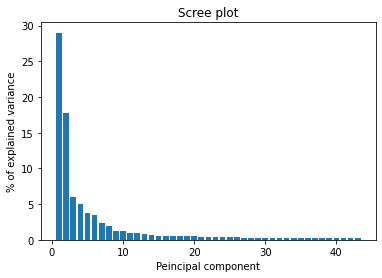

In [22]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()

As we can see from the above, each pixel has lower variance percentage than the pixel before,
and the first 2 pixels (pixel 1 and pixel 2) has the most variance percentage (in a high gap).

First, let's scatter a 3D graph using the pixel1, pixel2 and pixel3 (the pixels top 3 variance percentage)

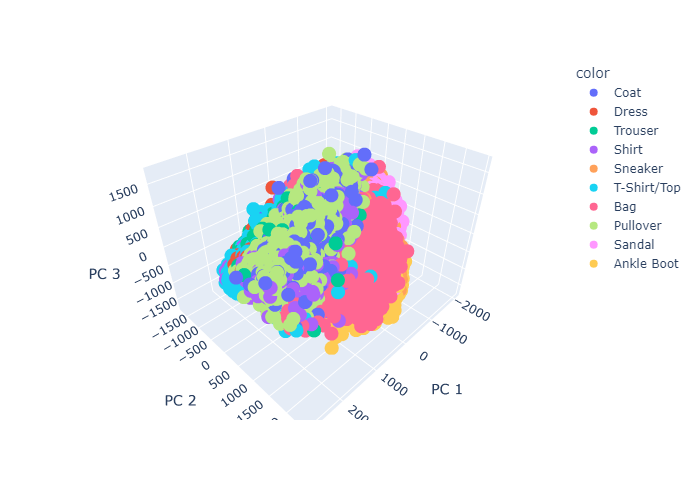

In [23]:
total_var = pca.explained_variance_ratio_.sum() * 100
y_train[0]
fig = px.scatter_3d(X_train_reduced,
    x=0, y=1, z=2, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show("png")

Well, this 3D graph is cool, it shows us how the data is spread in those 3 axis's.

Let's present a 2D graph with the 2 PC's that has the highest variance (PC1 and PC2 - 37%)

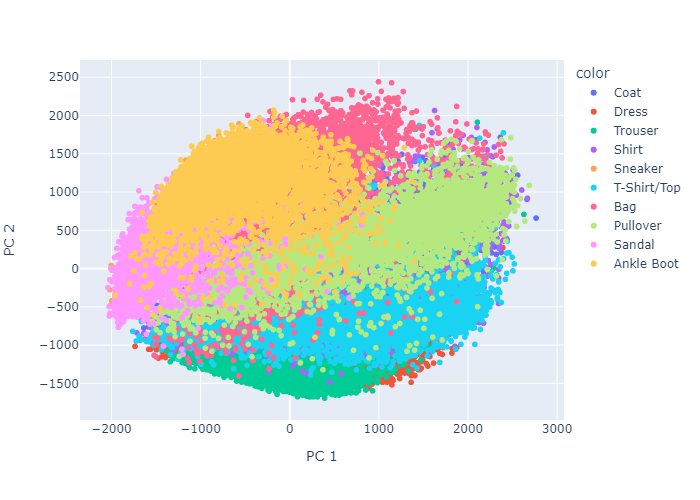

In [24]:
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

now we can actually see that if we will choose differnt axis's that we will see the data spread not as good as before,
because in the above we had a 2D graph with the top 2 variance percentage.

In other words, this graph will not neccessary be less good looking, but for sure it will be less accurate.

2D graph (PC2 and PC3)

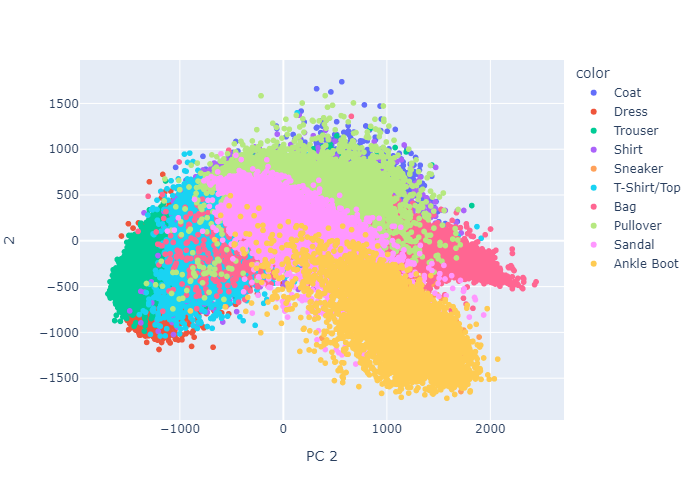

In [25]:
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = label_numbers_to_clothes(y_train),
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

2D graph(PC3 and PC1)

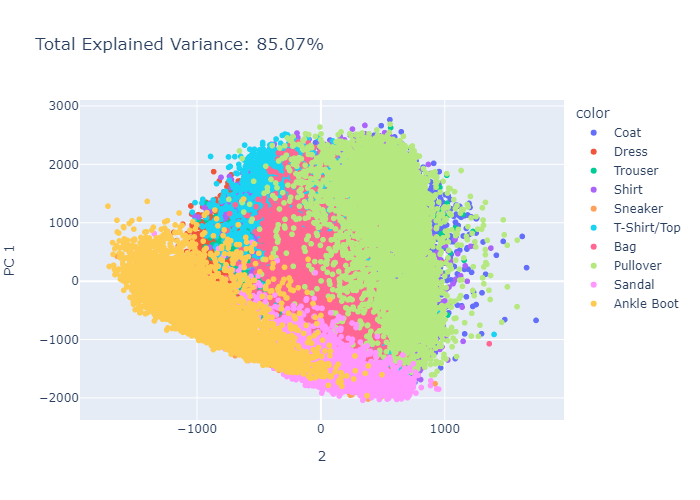

In [26]:
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=0, color = label_numbers_to_clothes(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

## Pipeline
before jumping into models, we will perform a dimensional reduction with scaling using pipeline

In [27]:
preprocess = Pipeline([('scaler',StandardScaler(with_std=False)), ('pca',PCA(n_components=0.85))])
X_train_reduced = preprocess.fit_transform(X_train)
X_val_reduced = preprocess.transform(X_val)

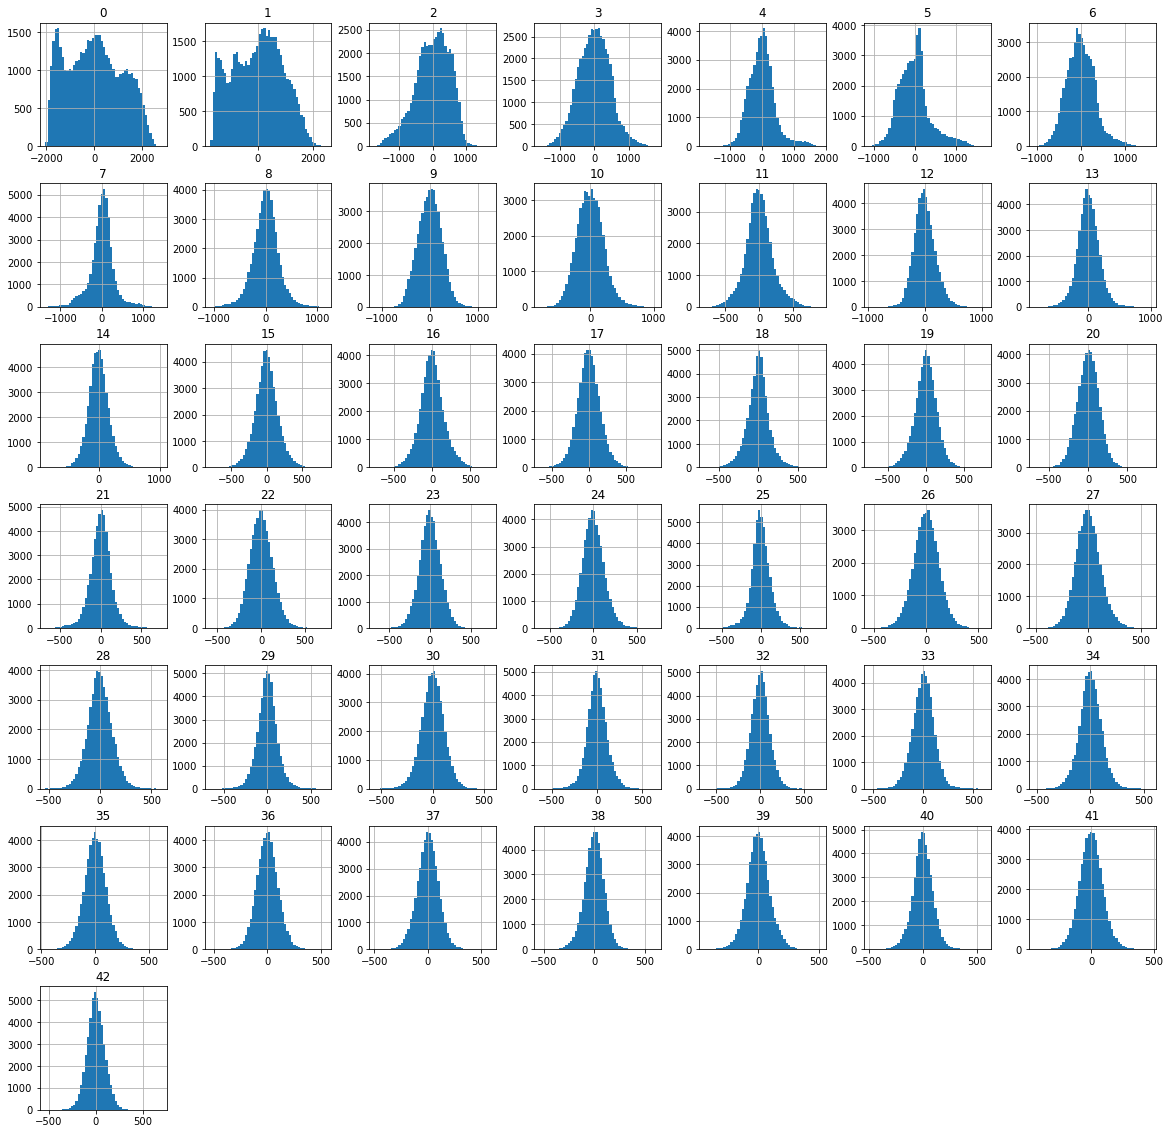

In [28]:
# Let's present the data distribution
temp = pd.DataFrame(X_train_reduced)
temp.hist(bins=50, figsize=(20,20))
plt.show()

As we can see from the above, the data in most of the pixels is normally distributed.

We will do a Pipeline also on the full data for the cross validation.

by creating a new PCA we are preventing data leakage

In [29]:
features_test = df_test.drop(['label'], axis = 1)
targets_test = df_test['label']

full_data_preprocess = Pipeline([('scaler',StandardScaler(with_std=False)), ('pca',PCA(n_components=0.85))])
features_train_reduced = full_data_preprocess.fit_transform(features_train)
features_test_reduced = full_data_preprocess.transform(features_test)

## Models

### DummyClassifier
A dummy classifier is a type of classifier which does not generate any insight about the data and classifies
the given data using only simple rules.

It is used only as a simple baseline for the other classifiers i.e. any other classifier
is expected to perform better on the given dataset.

In [30]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train_reduced,y_train)
y_pred = dm.predict(X_val_reduced)
dummy_acc = metrics.accuracy_score(y_val, y_pred)
print(dummy_acc)
print(classification_report(y_val,y_pred))

0.09533333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1150
           1       0.00      0.00      0.00      1191
           2       0.00      0.00      0.00      1249
           3       0.00      0.00      0.00      1217
           4       0.10      1.00      0.17      1144
           5       0.00      0.00      0.00      1215
           6       0.00      0.00      0.00      1224
           7       0.00      0.00      0.00      1144
           8       0.00      0.00      0.00      1217
           9       0.00      0.00      0.00      1249

    accuracy                           0.10     12000
   macro avg       0.01      0.10      0.02     12000
weighted avg       0.01      0.10      0.02     12000



<AxesSubplot:>

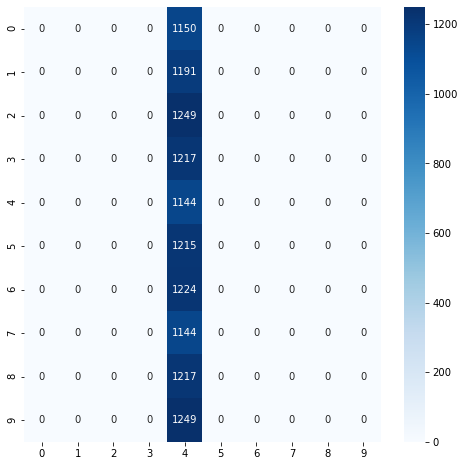

In [31]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [32]:
# Cross validation
dummy_acc = cross_val_score(DummyClassifier(strategy='most_frequent'), features_train_reduced, targets_train, cv = 10).mean()
print(dummy_acc)

0.1


Not suprisingly, we got a lame accuracy result because the dummy classifier will classify always the most frequent label,
which is the label 4.

Note: originally, there is no most frequent (each label has 6000 samples in the train part),
but from the random_state=7 we got that the most frequent label is 4

### KNN
knn is one of the simplest and widely used classification algorithms,
in which a new data point is classified based on similarity in the specific group of neighboring data points.

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_reduced,y_train)
y_pred = knn_clf.predict(X_val_reduced)
knn_acc = accuracy_score(y_val, y_pred)
print(knn_acc)
print (classification_report(y_val, y_pred))

0.8553333333333333
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1150
           1       0.99      0.96      0.98      1191
           2       0.75      0.77      0.76      1249
           3       0.89      0.88      0.89      1217
           4       0.74      0.78      0.76      1144
           5       0.97      0.89      0.93      1215
           6       0.68      0.57      0.62      1224
           7       0.89      0.93      0.91      1144
           8       0.97      0.97      0.97      1217
           9       0.90      0.95      0.93      1249

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.85     12000
weighted avg       0.86      0.86      0.85     12000



<AxesSubplot:>

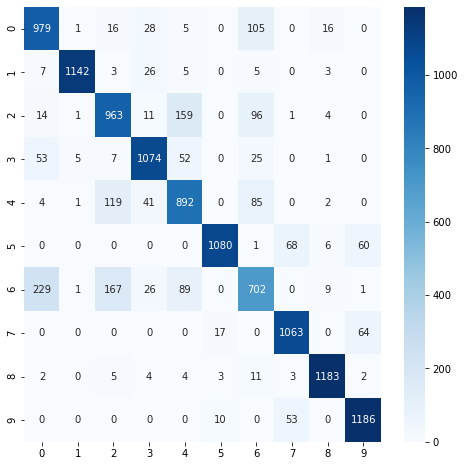

In [34]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [35]:
# finding the best k using cross validation
index = 0
max_score = -sys.maxsize
for i in range(1,21):
    acc = cross_val_score(KNeighborsClassifier(n_neighbors = i), features_train_reduced, targets_train, cv = 10).mean()
    if (acc > max_score):
        index = i
        max_score = acc
knn_acc = max_score
print(index, ":  ", max_score)

10 :   0.8592833333333333


### Logistic regression
Logistic Regression is a classification technique used in machine learning, by using a logistic function to model the dependent variable.

In [36]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_val_reduced)
lr_acc = accuracy_score(y_val, y_pred)
print(lr_acc)
print (classification_report(y_val, y_pred)) 

0.826
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1150
           1       0.97      0.95      0.96      1191
           2       0.74      0.71      0.72      1249
           3       0.82      0.85      0.84      1217
           4       0.68      0.74      0.71      1144
           5       0.93      0.91      0.92      1215
           6       0.59      0.50      0.54      1224
           7       0.88      0.90      0.89      1144
           8       0.93      0.93      0.93      1217
           9       0.93      0.93      0.93      1249

    accuracy                           0.83     12000
   macro avg       0.82      0.83      0.82     12000
weighted avg       0.82      0.83      0.82     12000



<AxesSubplot:>

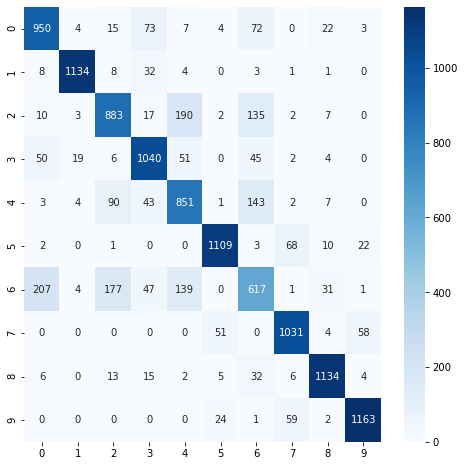

In [37]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [38]:
# Cross validation
lr_acc = cross_val_score(LogisticRegression(), features_train_reduced, targets_train, cv = 10).mean()
print(lr_acc)

0.8294833333333334


### Naive bayes
based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

In [39]:
bayes = GaussianNB()
bayes.fit(X_train_reduced, y_train)
y_pred = bayes.predict(X_val_reduced)
bayes_acc = accuracy_score(y_val, y_pred)
print(bayes_acc)
print (classification_report(y_val, y_pred))

0.7733333333333333
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1150
           1       1.00      0.90      0.94      1191
           2       0.67      0.65      0.66      1249
           3       0.77      0.82      0.79      1217
           4       0.70      0.67      0.68      1144
           5       0.86      0.80      0.83      1215
           6       0.49      0.48      0.49      1224
           7       0.82      0.88      0.85      1144
           8       0.83      0.88      0.85      1217
           9       0.90      0.90      0.90      1249

    accuracy                           0.77     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.77      0.77      0.77     12000



<AxesSubplot:>

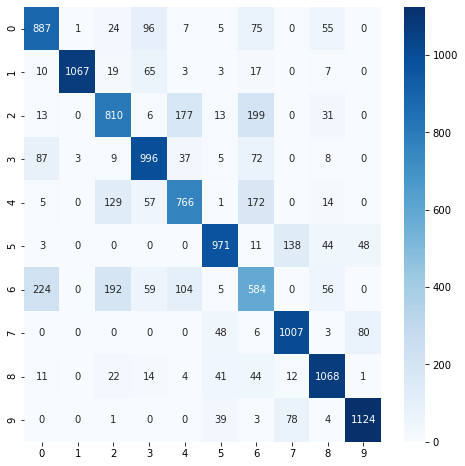

In [40]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [41]:
# Cross validation
bayes_acc = cross_val_score(GaussianNB(), features_train_reduced, targets_train, cv = 10).mean()
print(bayes_acc)

0.7755833333333333


### Random Forest
Random forest is comprised of multiple decision trees that work together as an ensemble to produce one prediction.

A decision tree is a logical construct that resembles a flowchart and illustrates a series of if-else statements

An important purpose of using random forest is to compensate for the limitations of decision tree algorithms by mapping multiple trees and using the forest's average output.

In [42]:
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train_reduced, y_train)
y_pred = rf.predict(X_val_reduced)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1150
           1       0.99      0.95      0.97      1191
           2       0.78      0.80      0.79      1249
           3       0.86      0.90      0.88      1217
           4       0.77      0.81      0.79      1144
           5       0.94      0.92      0.93      1215
           6       0.72      0.59      0.65      1224
           7       0.91      0.92      0.92      1144
           8       0.95      0.97      0.96      1217
           9       0.93      0.94      0.94      1249

    accuracy                           0.86     12000
   macro avg       0.86      0.87      0.86     12000
weighted avg       0.86      0.86      0.86     12000



<AxesSubplot:>

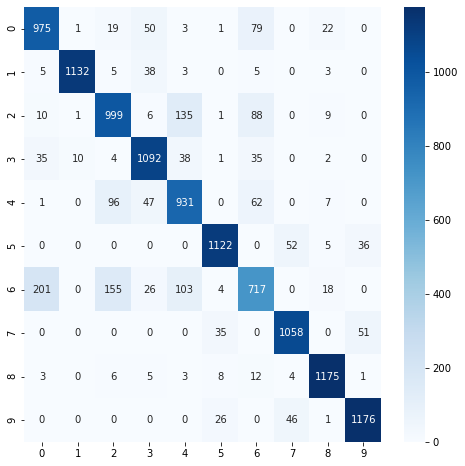

In [43]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [44]:
# Cross validation
rf_acc = cross_val_score(RandomForestClassifier(random_state=7), features_train_reduced, targets_train, cv = 10).mean()
print(rf_acc)

0.8657666666666666


### CatBoost
CatBoost is based on gradient boosted decision trees.
During training, a set of decision trees is built consecutively.

Each successive tree is built with reduced loss compared to the previous trees.

The number of trees is controlled by the starting parameters.

In [45]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train_reduced, y_train)
y_pred = cat.predict(X_val_reduced)
y_pred_cat = y_pred
cat_acc = accuracy_score(y_val, y_pred)
print(cat_acc)
print (classification_report(y_val, y_pred))

0.881
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1150
           1       0.99      0.97      0.98      1191
           2       0.81      0.82      0.81      1249
           3       0.88      0.91      0.89      1217
           4       0.78      0.82      0.80      1144
           5       0.96      0.94      0.95      1215
           6       0.75      0.65      0.70      1224
           7       0.92      0.93      0.93      1144
           8       0.95      0.97      0.96      1217
           9       0.95      0.95      0.95      1249

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



<AxesSubplot:>

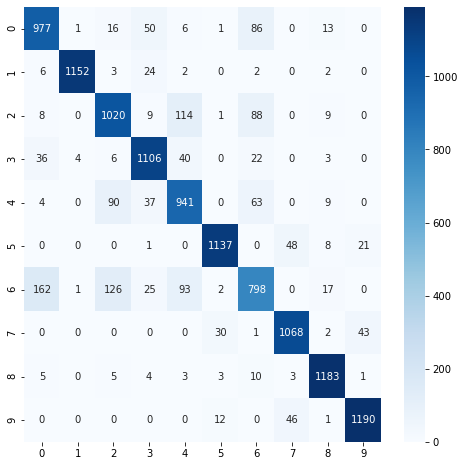

In [46]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [47]:
# Cross validation
cat_acc = cross_val_score(CatBoostClassifier(logging_level='Silent'), features_train_reduced, targets_train, cv = 10).mean()
print(cat_acc)

0.8797166666666667


### AdaBoost
AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique used as an Ensemble Method in Machine Learning.

It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights assigned to incorrectly classified instances.

In [48]:
rfc = RandomForestClassifier(random_state=7)
ada = AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc)
ada.fit(X_train_reduced, y_train)
y_pred = ada.predict(X_val_reduced)
ada_acc = accuracy_score(y_val, y_pred)
print(ada_acc)
print (classification_report(y_val, y_pred))

0.86475
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1150
           1       0.99      0.95      0.97      1191
           2       0.77      0.81      0.79      1249
           3       0.86      0.91      0.88      1217
           4       0.77      0.80      0.78      1144
           5       0.94      0.93      0.93      1215
           6       0.72      0.58      0.64      1224
           7       0.92      0.92      0.92      1144
           8       0.94      0.97      0.95      1217
           9       0.93      0.94      0.94      1249

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



<AxesSubplot:>

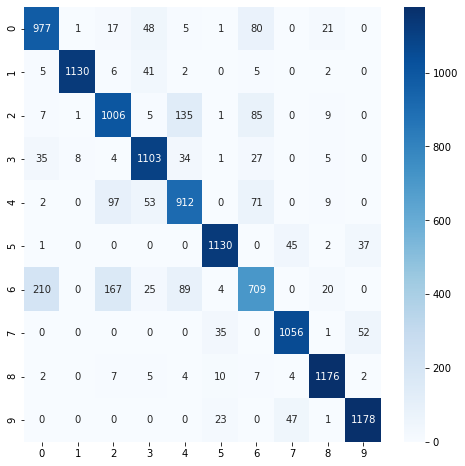

In [49]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [50]:
# Cross validation
ada_acc = cross_val_score(AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc), features_train_reduced, targets_train, cv = 10).mean()
print(ada_acc)

0.8662833333333333


### XGBoost
XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library.

It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [51]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(X_train_reduced, y_train)
y_pred = xgb.predict(X_val_reduced)
xgb_acc = accuracy_score(y_val, y_pred)
print(xgb_acc)
print (classification_report(y_val, y_pred))

0.8738333333333334
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1150
           1       0.99      0.96      0.98      1191
           2       0.80      0.81      0.80      1249
           3       0.88      0.90      0.89      1217
           4       0.79      0.82      0.80      1144
           5       0.96      0.93      0.95      1215
           6       0.69      0.63      0.66      1224
           7       0.92      0.94      0.93      1144
           8       0.96      0.97      0.96      1217
           9       0.95      0.95      0.95      1249

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



<AxesSubplot:>

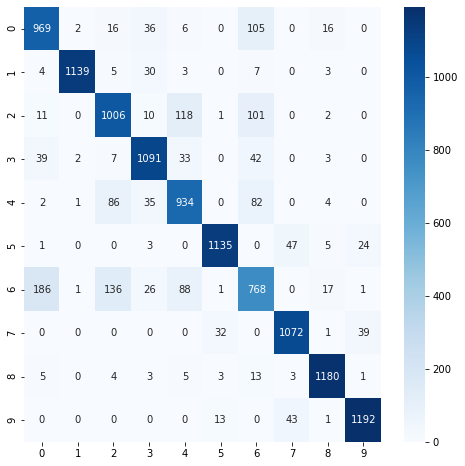

In [52]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [53]:
# Cross validation
xgb_acc = cross_val_score(XGBClassifier(use_label_encoder =False), features_train_reduced, targets_train, cv = 10).mean()
print(xgb_acc)

0.8751166666666667


### Voting
A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

In [54]:
# the classifiers we chose are between the more advanced one's
clf1 = xgb
clf2 = knn_clf
clf3 = rf
clf4 = cat

### Hard voting
In hard voting (also known as majority voting), every individual classifier votes for a class, and the majority wins.

In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted
labels.

In [55]:
hv = VotingClassifier(estimators=[('xgb', clf1), ('knn', clf2), ('rf', clf3)], voting='hard')
hv.fit(X_train_reduced, y_train)
y_pred = hv.predict(X_val_reduced)
hv_acc = accuracy_score(y_val, y_pred)
print(hv_acc)
print(classification_report(y_val, y_pred))

0.8726666666666667
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1150
           1       0.99      0.95      0.97      1191
           2       0.78      0.82      0.80      1249
           3       0.89      0.90      0.89      1217
           4       0.78      0.82      0.80      1144
           5       0.96      0.93      0.94      1215
           6       0.72      0.60      0.66      1224
           7       0.92      0.94      0.93      1144
           8       0.96      0.97      0.97      1217
           9       0.93      0.95      0.94      1249

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



<AxesSubplot:>

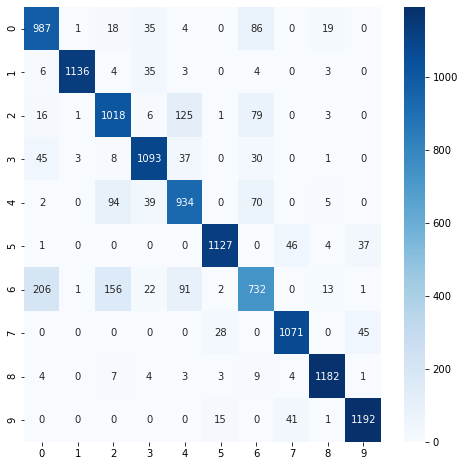

In [56]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [57]:
# Cross validation
hv_acc = cross_val_score(VotingClassifier(estimators=[('xgb', clf1), ('knn', clf2), ('rf', clf3)], voting='hard'), features_train_reduced, targets_train, cv = 10).mean()
print(hv_acc)

0.87415


### Soft voting
In soft voting, every individual classifier provides a probability value that a specific data point belongs
to a particular target class. The predictions are weighted by the classifier's importance and summed up.

Then the target label with the greatest sum of weighted probabilities wins the vote.

In [58]:
sv = VotingClassifier(estimators=[('xgb', clf1), ('cat', clf4), ('rf', clf3)], voting='soft', weights=[1,3,1])
sv.fit(X_train_reduced, y_train)
y_pred = sv.predict(X_val_reduced)
sv_acc = accuracy_score(y_val, y_pred)
print(sv_acc)
print(classification_report(y_val, y_pred))   

0.88125
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1150
           1       1.00      0.96      0.98      1191
           2       0.81      0.82      0.82      1249
           3       0.88      0.91      0.89      1217
           4       0.79      0.83      0.81      1144
           5       0.96      0.94      0.95      1215
           6       0.74      0.64      0.69      1224
           7       0.92      0.94      0.93      1144
           8       0.95      0.97      0.96      1217
           9       0.95      0.95      0.95      1249

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



<AxesSubplot:>

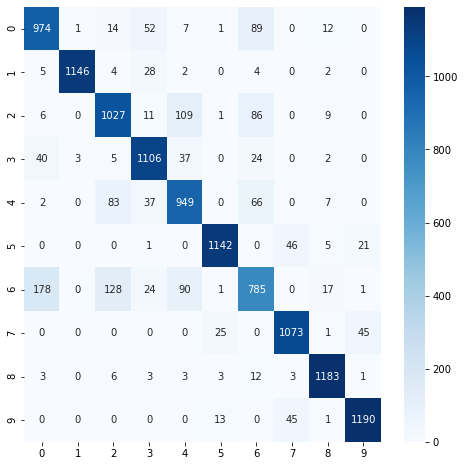

In [59]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

In [60]:
# Cross validation
sv_acc = cross_val_score(VotingClassifier(estimators=[('xgb', clf1), ('cat', clf4), ('rf', clf3)], voting='soft', weights=[1,3,1]), features_train_reduced, targets_train, cv = 10).mean()
print(sv_acc)

0.8815166666666666


### Stacking
The simplest form of stacking can be described as an ensemble learning technique where the predictions
of multiple classifiers (referred as level-one classifiers) are used as new features to train a meta-classifier.

The meta-classifier can be any classifier of your choice.

In [61]:
stc = StackingClassifier(estimators=[('knn',knn_clf), ('rf',rf), ('xgb',xgb),], final_estimator= xgb)
stc.fit(X_train_reduced,y_train)
stc.score(X_val_reduced, y_val)

0.8761666666666666

In [62]:
# Cross validation
stc_acc = cross_val_score(StackingClassifier(estimators=[('knn' , knn_clf), ('rf', rf), ('xgb' , xgb)], final_estimator=xgb), features_train_reduced, targets_train, cv = 10).mean()
print(stc_acc)

0.8768333333333335


## HyperParameters Tuning
For improvment, we will use GridSearchCV on our best model.

The best model is VotingClassifier with soft voting that got 88.15 accuracy.

The GridSearchCV chooses parameters between all of the possible combinations we have given in 'param_grid'.

Evantually, we can see which parameters combination gives us the best score.

In [63]:
# number of trees in the random forest.
n_estimators_list = [100, 500, 1000, 3000]
# maximum number of features to consider at every split,
# round(max_features * n_features) features are considered at each split.
max_features_list = np.arange(0.01,0.2,0.01)
# for each tree, N samples are drawn randomly with replacement from the training set (bootstrap)
# and the tree is built on this new version of the training data.
max_samples_list = [0.5,0.75,1.0]
# minimum sum of instance weight needed in a child.
min_child_weight = [1, 5, 10]
# minimum loss reduction required to make a further partition on a leaf node of the tree.
gamma = [0.5, 1, 1.5, 2, 5]
# maximum tree depth for base learners.
max_depth = [3, 4, 5]
params = {'rf__n_estimators':n_estimators_list,
          'rf__max_features':max_features_list,
          'rf__max_samples':max_samples_list,
          'xgb__min_child_weight': min_child_weight,
          'xgb__gamma': gamma,
          'xgb__max_depth': max_depth}
best_model = VotingClassifier(estimators=[('xgb', clf1), ('cat', clf4), ('rf', clf3)], voting='soft', weights=[1,3,1])
rs_model = RandomizedSearchCV(estimator = best_model,
                          param_distributions = params,
                          n_iter = 100,
                          n_jobs = -1,
                          cv = 10)

In [64]:
# fitting the training part
rs_model.fit(features_train_reduced, targets_train);

In [65]:
# The best parameters
best_parameters = rs_model.best_params_
print(best_parameters)

{'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'xgb__gamma': 2, 'rf__n_estimators': 500, 'rf__max_samples': 0.5, 'rf__max_features': 0.12}


### Predicting the test itself

In [66]:
y_pred = rs_model.predict(features_test_reduced)
rs_acc = accuracy_score(targets_test, y_pred)
print(rs_acc)
print(classification_report(targets_test, y_pred))

0.8792
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.80      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.85      0.83      1000
           5       0.95      0.93      0.94      1000
           6       0.72      0.66      0.69      1000
           7       0.91      0.91      0.91      1000
           8       0.96      0.97      0.96      1000
           9       0.92      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<AxesSubplot:>

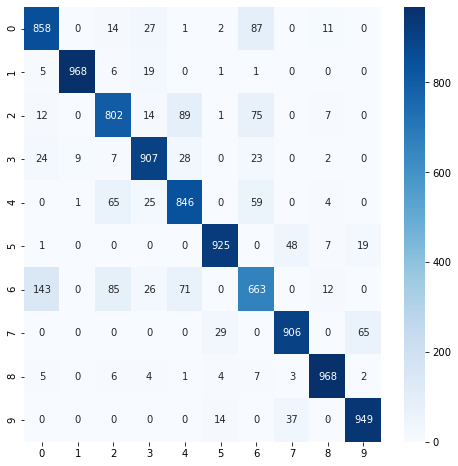

In [67]:
# let's present the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(targets_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

## Conclusion
The best model (between the models that we checked) for our dataset is: Soft voting classifier.

After a RandomizedSearchCV we improved it and got the best HyperParameters.

Our test score is: 0.8792.